In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

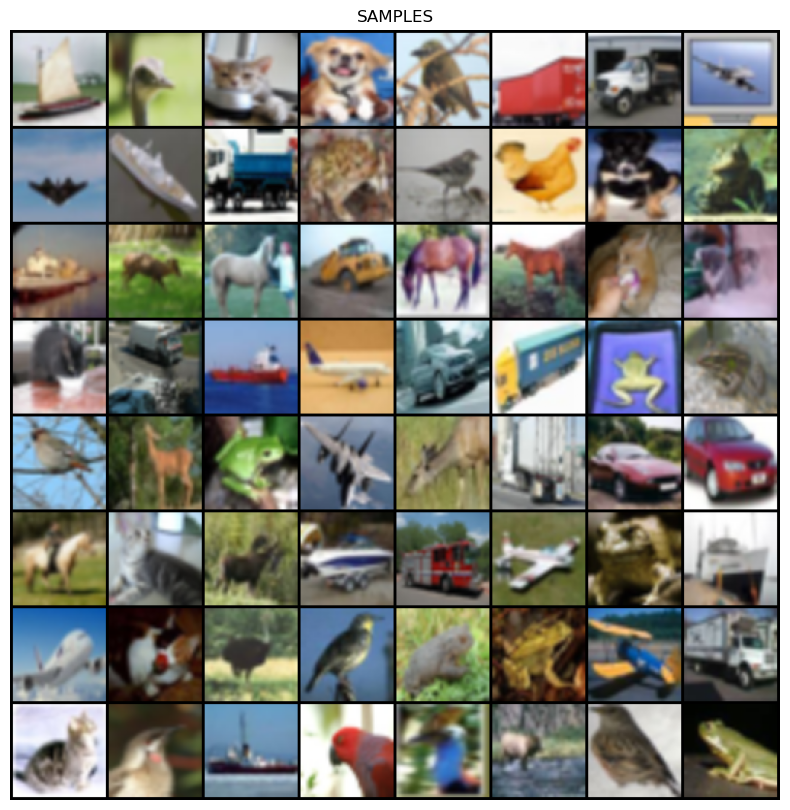

In [3]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("SAMPLES")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [4]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
           
            self.Gnet(channels_noise, features_g*8, 4, 1, 0),           
            self.Gnet(features_g*8, features_g*4, 4, 2, 1),  
            self.Gnet(features_g*4, features_g*2, 4, 2, 1),  
            self.Gnet(features_g*2, features_g, 4, 2, 1),      
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh() 
        
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
           
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine =True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [6]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def GP (critic, real, fake):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty
dis_features = 64 
gen_features = 64 
Channels_img = 3  
Noise_input = 100
BATCH_SIZE = 32
gen = Generator(Noise_input, Channels_img, gen_features).to(device)
disc = Discriminator(Channels_img, dis_features).to(device)
initialize_weights(gen)
initialize_weights(disc)
optimGenerator = optim.RMSprop(gen.parameters(), lr=6e-5)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=6e-5)
fixed_noise = torch.randn(BATCH_SIZE, Noise_input, 1, 1).to(device)
step = 0
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTr

In [7]:
class InceptionV3(nn.Module):    
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/home/anuprid/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anuprid/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


In [9]:
def sqrtm_approx(A, method='ss'):
    if method == 'ss':
        # Scaling and squaring method
        U, s, V = np.linalg.svd(A)
        s = np.diag(np.sqrt(s))
        return U.dot(s).dot(V)
    elif method == 'pi':
        # Power iteration method
        maxiter = 100
        tol = 1e-6
        X = np.eye(A.shape[0])
        for i in range(maxiter):
            Y = 0.5 * (X + A.dot(np.linalg.inv(X)))
            if np.max(np.abs(X - Y)) < tol:
                break
            X = Y
        return X
    else:
        raise ValueError("Invalid method: %s" % method)

In [10]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'
    
    diff = mu1 - mu2
    
    covmean = sqrtm_approx(sigma1.dot(sigma2), 'ss')

    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps

        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm_approx((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [11]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [12]:
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []
GP_weight = 10
criticItr = 5
MAX_EPOCHS = 50
for epoch in range(MAX_EPOCHS):
    epoch = epoch+1
    
    for batch_idx, data in enumerate(dataloader,0):
       
        real = data[0].to(device)
        batch = real.shape[0]
       
        for i in range (criticItr):
            noise = torch.randn(batch, Noise_input, 1, 1).to(device)
            fake = gen(noise) #genrator img data
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            gp = GP(disc, real,fake)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake))+ (GP_weight*gp))
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimDiscriminator.step()

        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output) 
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

        
        if (iters % 500 == 0) or ((epoch == MAX_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    if epoch > 0:
               print(f"Epoch  [{epoch}/{MAX_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  D-loss {loss_critic:.3f}, G-loss {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ")
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = gen(fixed_noise)

Epoch  [1/50] Batch 781/782                   D-loss -24.764, G-loss 108.476, FID Score: 313.902 
Epoch  [2/50] Batch 781/782                   D-loss -16.173, G-loss 91.110, FID Score: 322.897 
Epoch  [3/50] Batch 781/782                   D-loss -14.178, G-loss 99.433, FID Score: 367.724 
Epoch  [4/50] Batch 781/782                   D-loss -14.145, G-loss 123.175, FID Score: 367.914 
Epoch  [5/50] Batch 781/782                   D-loss -14.736, G-loss 117.928, FID Score: 353.026 
Epoch  [6/50] Batch 781/782                   D-loss -20.030, G-loss 115.784, FID Score: 348.178 
Epoch  [7/50] Batch 781/782                   D-loss -21.756, G-loss 131.049, FID Score: 342.336 
Epoch  [8/50] Batch 781/782                   D-loss -15.719, G-loss 131.475, FID Score: 355.125 
Epoch  [9/50] Batch 781/782                   D-loss -16.092, G-loss 132.172, FID Score: 388.485 
Epoch  [10/50] Batch 781/782                   D-loss -16.392, G-loss 143.357, FID Score: 360.140 
Epoch  [11/50] Batch 

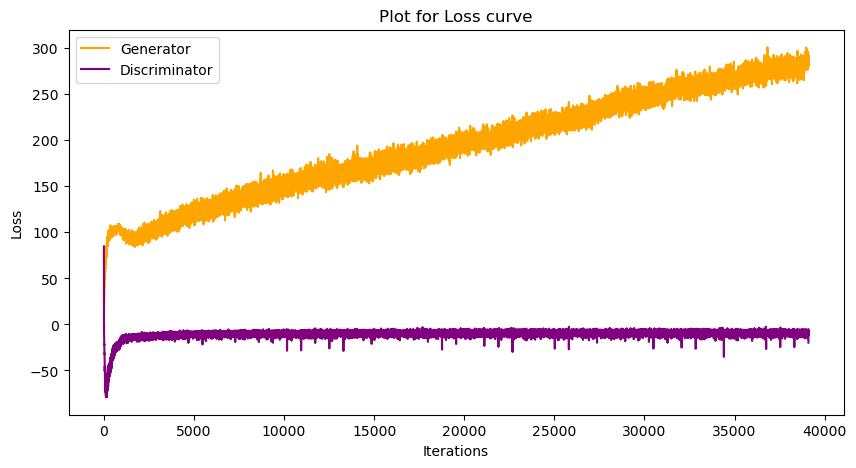

In [13]:
plt.figure(figsize=(10,5))
plt.title("Plot for Loss curve")
plt.plot(GenLoss, label="Generator", color="Orange")
plt.plot(DiscLoss, label="Discriminator", color="purple")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

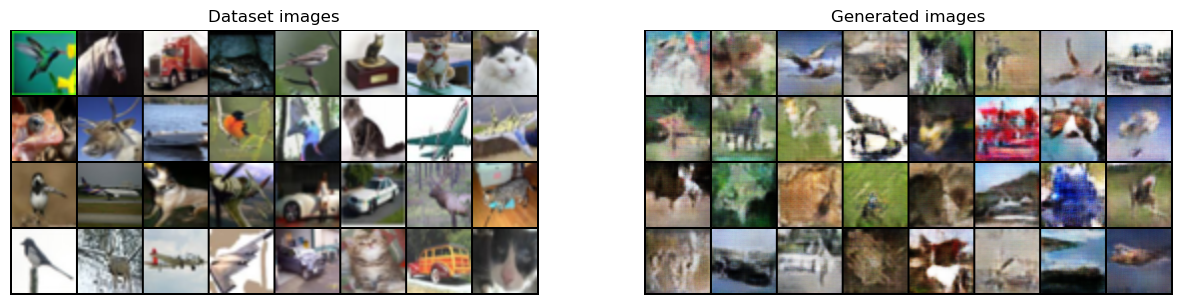

In [15]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Dataset images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

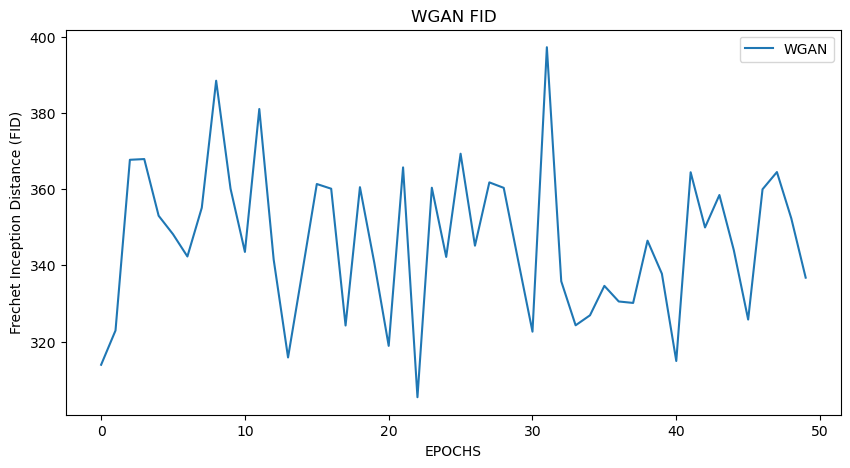

In [16]:
plt.figure(figsize=(10,5))
plt.title("WGAN FID")
plt.plot(FID_list,label="WGAN")
plt.xlabel("EPOCHS")
plt.ylabel("Frechet Inception Distance (FID)")
plt.legend()
plt.show()